In [32]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error
from sklearn.decomposition import PCA


## Carregando CDC Diabetes Health Indicators dataset.

In [33]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
   
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
print(f"{(100*(y.value_counts()[1] / y.count().iloc[0])):.2f}% de observações positivas de diabéticos. Há um Desequilibrio de classes nos dados.")  
X.columns

X.describe()

13.93% de observações positivas de diabéticos. Há um Desequilibrio de classes nos dados.


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


### Considerações Iniciais
Por questões técnicas de capacidade computacional foi reduzido o volume de dados a 40% do valor original respeitando as proporções inicias dos dados.

In [34]:
X_reduzido,X_restante ,y_reduzido ,y_restante = train_test_split(X, y, train_size=0.40, random_state=7, shuffle=True, stratify=y)

### 1. Estruturação Conceitual do Problema
- Primeiramente o modelo supervisionado tem por caracteristica própria a tarefa de classificação e regressão, ou seja, necessita de features bem estruturadas (categorias numéricas, binarias e ordinais) e com um target (númerico, geralmente binário para classificações). Considerando o dataset CDC Diabetes Health Indicators e o Problema a ser tratado temos exatamente as mesmas características, features com características numéricas e computáveis e a necessidade de analisar novas observações para classificar a positividade da diabetes. Tudo isso se encaixa no modelo de treinamento supervisionado. 
- O treinamento deste modelo supervisionado consiste em encontrar parâmetros para o modelo que minimiza uma função de risco/erro para uma amostra de treinamento, baseado na diferença entre os valores previstos e reais das observações. São então encontrados algums desafios relevantes para o desenvolvimento do modelo de previsão, que são a baixa variância causada pelas muitas variaveis binarias além do problema de gerar uma regressão com estes dados, e temos o desequilibrio entre classes que consiste numa maior quantidade de observações de não diabeticos do que diabeticos (13.93% das observações) causando um tendencia a classificar como falso a presença de diabetes.
- As bibliotecas python utilizadas mais relevantes são a biblioteca pandas, para a manipulação de dados como carregar, explorar e transformar DataFrames. A bibliteca Scikit-Learn, que tem uma gama de ferramentas e modelos, como normalização de dados, metricas e sorteadores de observação, para a efetivação do modelo de previsões almejado, pré-processamento dos dados e avalição do modelo. E a biblioteca Matplotlib, que é usada para visualizar os dados, distribuições e correlações.

### 2. Implementação do Modelo K-Nearest Neighbors


- Algumas features foram escolhidas por relevância técnica no diagnostico médico para diabetes outras por representarem fatores de risco para se manifestar a diabetes.

In [35]:
# Features explicativas
features = [
    'BMI',                  # Índice de Massa Corporal (contínuo)
    'Age',                  # Idade (ordinal: 1-13 faixas etárias)
    'HighBP',               # Hipertensão (binária)
    'HighChol',             # Colesterol alto (binário)
    'GenHlth',              # Saúde geral (ordinal: 1-5)
    'HeartDiseaseorAttack', # Doença cardíaca (binária)
    'PhysHlth',             # Saúde física ruim (contínuo: 0-30)
    'DiffWalk',             # Dificuldade para caminhar (binária)
    'Sex'                   # Gênero (binário)
]

# Já as features deixadas de fora ou são correlatas como BMI e Weight ou tem relevancia minima como AnyHealthCare (possuir plano de saúde)

- Neste modelo se deve utilizar o estratificador no sorteamento de features para deixar constante a proporção entre casos positivos e negativos de diabetes.
- Deve-se também normalizar as variáveis numéricas. Pois o modelo KNN é sensível a escalas, podendo ser prejudicado por diferentes escalas no mecanismo do algorítimo dos 'vizinhos mais próximos'.
- Após a normalização há a hiperparametrização do modelo KNN pela variavel K, para achar o parâmetro mais adequado a solução do problema.

In [36]:
X_selecionado = X_reduzido[features] # Seleção das Features no Dataset inteiro

# Sorteamento das observações com estratificação, proporção constante entre targets positivos e negativos a serem separados.
X_treino,X_teste, y_treino,y_teste = train_test_split(X_selecionado,y_reduzido ,test_size=0.2, stratify=y_reduzido, random_state=7) 
y_treino= y_treino.values.ravel()
y_teste = y_teste.values.ravel()


In [37]:
features_to_normalize = ['BMI', 'PhysHlth', 'GenHlth', 'Age'] # Features a serem normalizadas

# Processo de Normalização do X_treino
normalizador1 = StandardScaler()
features_treino_normalizado = normalizador1.fit_transform(X_treino[features_to_normalize])
features_treino_normalizado = pd.DataFrame(features_treino_normalizado, columns=normalizador1.get_feature_names_out(), index=X_treino.index)
X_treino_normalizado = pd.concat([X_treino.drop(features_to_normalize, axis=1), features_treino_normalizado], axis=1)
print(X_treino_normalizado)

# Processo de Normalização do X_teste
normalizador2 = StandardScaler()
features_teste_normalizado = normalizador2.fit_transform(X_teste[features_to_normalize])
features_teste_normalizado = pd.DataFrame(features_teste_normalizado, columns=normalizador2.get_feature_names_out(), index=X_teste.index)
X_teste_normalizado = pd.concat([X_teste.drop(features_to_normalize, axis=1), features_teste_normalizado], axis=1)
print(X_teste_normalizado)

        HighBP  HighChol  HeartDiseaseorAttack  DiffWalk  Sex       BMI  \
141850       0         1                     0         0    0  0.244236   
221803       0         0                     0         0    0 -0.362213   
215487       0         0                     0         0    0 -1.423497   
39333        1         0                     0         0    1 -0.058989   
101995       0         0                     1         0    1 -0.968661   
...        ...       ...                   ...       ...  ...       ...   
41189        1         1                     1         1    1  0.547460   
18727        0         0                     0         0    1 -0.513825   
140208       0         0                     0         0    1 -0.513825   
131506       1         1                     0         0    0 -0.210601   
199748       1         0                     0         0    1  0.244236   

        PhysHlth   GenHlth       Age  
141850 -0.487230 -0.480433 -0.011588  
221803 -0.487230 -1.4

In [38]:
metricas_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score
}

metricas_modelos = []

# Treinamento e metricas de previsão de modelos KNN variando de 1 a 18
Ks = [k for k in range(1,21,1)]
for K in Ks:
    modelo_KNN = KNeighborsClassifier(n_neighbors=K)
    modelo_KNN.fit(X_treino_normalizado, y_treino)
    
    # Aquisição de cada Métrica para o Modelo.
    for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
        metrica_avaliada_treino = metricas_dict[metrica](y_treino, modelo_KNN.predict(X_treino_normalizado))
        metrica_avaliada_teste = metricas_dict[metrica](y_teste, modelo_KNN.predict(X_teste_normalizado))
        metricas_modelos.append({'K': K, 'stat' : 'treino', 'metrica': metrica , 'valor': metrica_avaliada_treino})
        metricas_modelos.append({'K': K, 'stat' : 'teste', 'metrica': metrica, 'valor': metrica_avaliada_teste})

### Utilização da métricas
- As métricas utilizadas como alicerce da análise são recall e acurácia.
- A acurácia indica os acertos absolutos do sistema, tanto em treinamento quanto em teste.
- Já o recall indica a porcentagem de resultados positivos para diabetes pelo total de positivos testado no modelo. Indicando quantos acertos positivos para a doença foram realizados. O que é importante na analise médica no caso de previsões acertivas da doença.

In [39]:
metricas_modelos = pd.DataFrame().from_records(metricas_modelos)

# Seleção dos melhores modelos com melhor K por Recall
modelos = metricas_modelos.groupby(['K', 'metrica']).agg({'stat': list, 'valor': ['mean','max', 'min']})
melhores_modelos = modelos.sort_values(
    by=['metrica', ('valor', 'mean'),('valor', 'max'), ('valor', 'min'), 'K'],
    key=lambda x: (~x.str.contains('recall', case=False, na=False)) if x.name == 'metrica' else x, 
    ascending=[True,False,False,False, False])
idx_melhores_k_recall = melhores_modelos.index[0:20]
melhores_modelos_k = []
for k, _ in idx_melhores_k_recall:
    for metrica in ['accuracy','precision', 'recall']:
        melhores_modelos_k.append(melhores_modelos.loc[(k,metrica)])

melhores_modelos_k = pd.DataFrame(melhores_modelos_k)
melhores_modelos_k.sort_values(
    by=[('valor', 'mean'),('valor', 'max'), ('valor', 'min')], 
    ascending=[False,False, False])

stat     valor                    
                         list      mean       max       min
2  accuracy   [treino, teste]  0.872738  0.893295  0.852180
4  accuracy   [treino, teste]  0.869221  0.882959  0.855482
6  accuracy   [treino, teste]  0.868056  0.878808  0.857305
8  accuracy   [treino, teste]  0.867477  0.876123  0.858832
12 accuracy   [treino, teste]  0.867169  0.873437  0.860902
14 accuracy   [treino, teste]  0.866997  0.872156  0.861838
16 accuracy   [treino, teste]  0.866843  0.871749  0.861936
15 accuracy   [treino, teste]  0.866794  0.872686  0.860902
20 accuracy   [treino, teste]  0.866720  0.870665  0.862774
7  accuracy   [treino, teste]  0.866603  0.878759  0.854447
17 accuracy   [treino, teste]  0.866498  0.871946  0.861050
13 accuracy   [treino, teste]  0.866467  0.873560  0.859374
18 accuracy   [treino, teste]  0.866381  0.870924  0.861838
10 accuracy   [treino, teste]  0.866319  0.874644  0.857995
9  accuracy   [treino, teste]  0.866110  0.876049  0.856171
11 accuracy   [treino, teste]  0.866098  0.874250  0.857945
19 accuracy   [treino, teste]  0.866011  0.870875  0.861148
1  accuracy   [treino, teste]  0.865846  0.921542  0.810150
3  accuracy   [treino, teste]  0.865716  0.893147  0.838285
5  accuracy   [treino, teste]  0.865568  0.881567  0.849569
2  precision  [treino, teste]  0.647143  0.894988  0.399297
4  precision  [treino, teste]  0.597016  0.756015  0.438017
6  precision  [treino, teste]  0.584095  0.707910  0.460280
8  precision  [treino, teste]  0.579399  0.680796  0.478002
14 precision  [treino, teste]  0.579230  0.643385  0.515075
20 precision  [treino, teste]  0.578725  0.629346  0.528105
16 precision  [treino, teste]  0.577987  0.638777  0.517196
12 precision  [treino, teste]  0.577191  0.651373  0.503008
18 precision  [treino, teste]  0.573658  0.632316  0.515000
10 precision  [treino, teste]  0.567265  0.667060  0.467470
15 precision  [treino, teste]  0.559821  0.617159  0.502483
17 precision  [treino, teste]  0.559644  0.615094  0.504193
19 precision  [treino, teste]  0.556577  0.607869  0.505285
13 precision  [treino, teste]  0.553951  0.620119  0.487782
11 precision  [treino, teste]  0.546818  0.618038  0.475599
7  precision  [treino, teste]  0.545781  0.640023  0.451538
9  precision  [treino, teste]  0.543556  0.625251  0.461861
5  precision  [treino, teste]  0.531890  0.637841  0.425938
3  precision  [treino, teste]  0.526475  0.676723  0.376227
1  precision  [treino, teste]  0.518323  0.720403  0.316242
   recall     [treino, teste]  0.512926  0.713970  0.311881
3  recall     [treino, teste]  0.345115  0.446242  0.243989
5  recall     [treino, teste]  0.287867  0.346950  0.228784
7  recall     [treino, teste]  0.252104  0.296640  0.207567
9  recall     [treino, teste]  0.235129  0.275420  0.194837
11 recall     [treino, teste]  0.222309  0.255084  0.189533
13 recall     [treino, teste]  0.211124  0.238727  0.183522
15 recall     [treino, teste]  0.202990  0.227056  0.178925
17 recall     [treino, teste]  0.193133  0.216180  0.170085
2  recall     [treino, teste]  0.192916  0.265252  0.120580
19 recall     [treino, teste]  0.187651  0.206278  0.169024
4  recall     [treino, teste]  0.183675  0.236163  0.131188
6  recall     [treino, teste]  0.180447  0.221574  0.139321
8  recall     [treino, teste]  0.175452  0.208753  0.142150
12 recall     [treino, teste]  0.172445  0.197082  0.147808
10 recall     [treino, teste]  0.168688  0.200177  0.137199
14 recall     [treino, teste]  0.164930  0.184881  0.144979
18 recall     [treino, teste]  0.160730  0.175774  0.145686
16 recall     [treino, teste]  0.160598  0.182935  0.138260
20 recall     [treino, teste]  0.158652  0.174447  0.142857

### Analise dos resultados de 20 treinamentos de melhor Recall
- Primeiramente nota-se que por causa do desbalanceamento de classes e underfitting nos modelos, com excessão de k = 1. Isso é visivel pelos indices accuracy dando quase a mesma porcentagem de casos com diabetes e recall de testes proximo a 25% para os dois melhores K's 1 e 3, o que significa que o modelo está basicamente escolhendo a classe, sem diabetes, para resposta de viés dominante. Já o acurácia indica que esse viés segue a proporção de casos com e sem diabetes.
- A precisão indica que os dados de treino tem um bom retorno, mas os de teste parecem ser divergente do padrão.
- Por enquanto é inconclusivo o melhor k, mas temos as 2 melhores opções do momento que é o k = 1 e k = 3.
- O melhor k será melhor identificado na análise com kFolds.

### 3. Validação Cruzada e comparação entre modelos.
- A validação cruzada permite uma comparação mais robusta entre os modelos, pois possibilita gerar modelos com dados de treinamento diferentes, pois permite que diferentes estatísticas possam ser geradas para a análise dos hiperparâmetros.

In [40]:
metricas_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score,
    'r2_score':r2_score,
    'mean_absolute_error': mean_absolute_error
}
metricas_modelos_fold = []

kfolds = 5
idx_fold = 0
skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=7)
for idx_treino, idx_teste in skf.split(X_selecionado, y_reduzido):
    X_treino, X_teste = X_selecionado.iloc[idx_treino], X_selecionado.iloc[idx_teste]
    y_treino, y_teste = y.iloc[idx_treino].values.ravel(), y.iloc[idx_teste].values.ravel()

    normalizador1 = StandardScaler()
    features_treino_normalizado = normalizador1.fit_transform(X_treino[features_to_normalize])
    features_treino_normalizado = pd.DataFrame(features_treino_normalizado, columns=normalizador1.get_feature_names_out(), index=X_treino.index)
    X_treino_normalizado = pd.concat([X_treino.drop(features_to_normalize, axis=1), features_treino_normalizado], axis=1)

    normalizador2 = StandardScaler()
    features_teste_normalizado = normalizador2.fit_transform(X_teste[features_to_normalize])
    features_teste_normalizado = pd.DataFrame(features_teste_normalizado, columns=normalizador2.get_feature_names_out(), index=X_teste.index)
    X_teste_normalizado = pd.concat([X_teste.drop(features_to_normalize, axis=1), features_teste_normalizado], axis=1)

    Ks = [k for k in range(1,19,1)]
    for K in Ks:
        modelo_KNN = KNeighborsClassifier(n_neighbors=K)
        modelo_KNN.fit(X_treino_normalizado, y_treino)

        for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
            metrica_avaliada_treino = metricas_dict[metrica](y_treino, modelo_KNN.predict(X_treino_normalizado))
            metrica_avaliada_teste = metricas_dict[metrica](y_teste, modelo_KNN.predict(X_teste_normalizado))
            metricas_modelos_fold.append({'modelo': f"K-{K}", 'fold': idx_fold, 'stat' : 'treino', 'metrica': metrica , 'valor': metrica_avaliada_treino})
            metricas_modelos_fold.append({'modelo': f"K-{K}", 'fold': idx_fold, 'stat' : 'teste', 'metrica': metrica, 'valor': metrica_avaliada_teste})
    
    modelo_LGR = LogisticRegression(random_state=7, max_iter=500)
    modelo_LGR.fit(X_treino_normalizado, y_treino)
    for metrica in ['accuracy','mean_absolute_error','r2_score']:
        metrica_avaliada_treino = metricas_dict[metrica](y_treino, modelo_LGR.predict(X_treino_normalizado))
        print(metrica_avaliada_treino)
        metrica_avaliada_teste = metricas_dict[metrica](y_teste, modelo_LGR.predict(X_teste_normalizado))
        metricas_modelos_fold.append({'modelo': 'LGR', 'fold': idx_fold, 'stat' : 'treino', 'metrica': metrica , 'valor': metrica_avaliada_treino})
        metricas_modelos_fold.append({'modelo': 'LGR', 'fold': idx_fold, 'stat' : 'teste', 'metrica': metrica, 'valor': metrica_avaliada_teste})
        modelo_LGR.predict
    idx_fold += 1 



c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8605639528437858
0.1394360471562142
-0.1620286867645797


c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.859701639626988
0.14029836037301205
-0.1631942454290134


c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8604917588509202
0.1395082411490798
-0.1621261792621651


c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8599497400773609
0.14005025992263914
-0.1628586571931987


c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josem\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8599866959028308
0.1400133040971692
-0.16280868618575584


In [41]:
metricas_modelos_fold = pd.DataFrame().from_records(metricas_modelos_fold)

# Seleção dos melhores modelos com melhor K por Recall
modelos = metricas_modelos_fold.groupby(['modelo','fold', 'metrica']).agg({'stat': list, 'valor': ['mean','max', 'min']})
melhores_modelos = modelos.sort_values(
    by=['metrica',('valor', 'mean'),('valor','max'), ('valor', 'min')],
    key=lambda x: (~x.str.contains('recall', case=False, na=False)) if x.name == 'metrica' else x, 
    ascending=[True,False, False,False])
idx_melhores_modelos_recall = melhores_modelos.index[0:20]
melhores_modelos_final = []
for modelo, fold, _ in idx_melhores_modelos_recall:
    for metrica in ['accuracy','precision', 'recall']:
        melhores_modelos_final.append(melhores_modelos.loc[modelo, fold, metrica])


melhores_modelos_final = pd.DataFrame(melhores_modelos_final)
melhores_modelos_final.index.names=['modelo','fold', 'metrica']
melhores_modelos_final = melhores_modelos_final.reset_index(level=['modelo','fold', 'metrica'])
melhores_modelos_final.sort_values(
    by=['metrica', ('valor', 'mean'), ('valor', 'min')],
    ascending=[False, False,False], ignore_index= True
)

modelo fold    metrica             stat     valor                    
                                      list      mean       max       min
0     K-1    1     recall  [treino, teste]  0.340367  0.540170  0.140564
1     K-1    3     recall  [treino, teste]  0.338266  0.527399  0.149132
2     K-1    4     recall  [treino, teste]  0.336224  0.526658  0.145789
3     K-1    2     recall  [treino, teste]  0.336181  0.535982  0.136379
4     K-1    0     recall  [treino, teste]  0.330524  0.524605  0.136443
5     K-3    0     recall  [treino, teste]  0.123054  0.186589  0.059520
6     K-3    4     recall  [treino, teste]  0.122710  0.189865  0.055556
7     K-3    2     recall  [treino, teste]  0.119758  0.187196  0.052319
8     K-3    3     recall  [treino, teste]  0.119197  0.182426  0.055969
9     K-3    1     recall  [treino, teste]  0.116531  0.185969  0.047092
10    K-2    2     recall  [treino, teste]  0.056331  0.091038  0.021625
11    K-2    3     recall  [treino, teste]  0.054565  0.087167  0.021962
12    K-2    0     recall  [treino, teste]  0.052480  0.087905  0.017055
13    K-2    1     recall  [treino, teste]  0.051967  0.088594  0.015341
14    K-2    4     recall  [treino, teste]  0.050193  0.084462  0.015924
15    K-5    2     recall  [treino, teste]  0.049510  0.073907  0.025113
16    K-5    3     recall  [treino, teste]  0.048443  0.077403  0.019483
17    K-5    4     recall  [treino, teste]  0.047740  0.075664  0.019816
18    K-5    1     recall  [treino, teste]  0.047130  0.074282  0.019979
19    K-5    0     recall  [treino, teste]  0.047065  0.073593  0.020536
20    K-2    3  precision  [treino, teste]  0.358573  0.577506  0.139640
21    K-2    4  precision  [treino, teste]  0.354285  0.590769  0.117801
22    K-2    0  precision  [treino, teste]  0.354000  0.567598  0.140401
23    K-2    2  precision  [treino, teste]  0.350973  0.582486  0.119461
24    K-2    1  precision  [treino, teste]  0.338976  0.569092  0.108861
25    K-1    4  precision  [treino, teste]  0.317666  0.497631  0.137701
26    K-1    0  precision  [treino, teste]  0.316621  0.494627  0.138614
27    K-1    1  precision  [treino, teste]  0.314593  0.492475  0.136711
28    K-1    3  precision  [treino, teste]  0.314356  0.491355  0.137357
29    K-1    2  precision  [treino, teste]  0.313173  0.490347  0.136000
30    K-5    2  precision  [treino, teste]  0.304400  0.474221  0.134579
31    K-3    2  precision  [treino, teste]  0.302002  0.467888  0.136116
32    K-3    0  precision  [treino, teste]  0.299815  0.432964  0.166667
33    K-5    4  precision  [treino, teste]  0.299223  0.471750  0.126697
34    K-5    1  precision  [treino, teste]  0.298779  0.474481  0.123077
35    K-5    3  precision  [treino, teste]  0.294378  0.460251  0.128505
36    K-3    3  precision  [treino, teste]  0.294171  0.449502  0.138840
37    K-3    1  precision  [treino, teste]  0.294149  0.461740  0.126558
38    K-5    0  precision  [treino, teste]  0.293661  0.436812  0.150510
39    K-3    4  precision  [treino, teste]  0.291724  0.453266  0.130182
40    K-2    4   accuracy  [treino, teste]  0.854990  0.863621  0.846359
41    K-2    0   accuracy  [treino, teste]  0.854777  0.863483  0.846070
42    K-2    1   accuracy  [treino, teste]  0.854691  0.862720  0.846662
43    K-2    3   accuracy  [treino, teste]  0.854177  0.863226  0.845127
44    K-5    1   accuracy  [treino, teste]  0.851784  0.858581  0.844986
45    K-2    2   accuracy  [treino, teste]  0.851676  0.864089  0.839263
46    K-5    3   accuracy  [treino, teste]  0.851651  0.858077  0.845225
47    K-5    4   accuracy  [treino, teste]  0.851602  0.858718  0.844486
48    K-5    0   accuracy  [treino, teste]  0.851266  0.857595  0.844937
49    K-5    2   accuracy  [treino, teste]  0.849415  0.859371  0.839460
50    K-3    1   accuracy  [treino, teste]  0.839441  0.855378  0.823503
51    K-3    0   accuracy  [treino, teste]  0.838621  0.852507  0.824735
52    K-3    2   accuracy  [treino, teste]  0.838057  0.85690

### Resultado KNN 5 folds
- Com a inclusão da validação cruzada vemos que os indices das métricas pioram, ou seja, é mais confiável que não haja uma correlação direta entre as features e o target, gerando um underfitting no modelo de previsão.
- Os indices indicam que não há um padrão KNN reconhecível nos modelos, ou seja, não a separação na região das features que separe bem as classes a serem identificadas.
- De qualquer forma, apesar dos péssimos índices dos modelos, o modelo k = 1, com media de acurácia e recall de treino e teste de 83% e 42% respectivamente , foi o que obteve maior recall, característica visada em diagnósticos médicos.

In [42]:
# melhor Regressão Logistica
modelos = metricas_modelos_fold['modelo'] == 'LGR'
modelos = metricas_modelos_fold.loc[modelos].groupby(['fold' ,'metrica']).agg({'stat': list, 'valor': ['mean', 'min']})
melhores_modelos = modelos.sort_values(
    by=['metrica',('valor', 'mean'), ('valor', 'min')],
    key=lambda x: (~x.str.contains('r2_score', case=False, na=False)) if x.name == 'metrica' else x, 
    ascending=[True,False, False])
melhores_modelos

stat     valor          
                                     list      mean       min
fold metrica                                                 
1    r2_score             [treino, teste] -0.161719 -0.163194
3    r2_score             [treino, teste] -0.162220 -0.162859
4    r2_score             [treino, teste] -0.162295 -0.162809
2    r2_score             [treino, teste] -0.163321 -0.164515
0    r2_score             [treino, teste] -0.163468 -0.164906
1    accuracy             [treino, teste]  0.860794  0.859702
3    accuracy             [treino, teste]  0.860422  0.859950
4    accuracy             [treino, teste]  0.860367  0.859987
2    accuracy             [treino, teste]  0.859609  0.858727
0    accuracy             [treino, teste]  0.859501  0.858438
     mean_absolute_error  [treino, teste]  0.140499  0.139436
2    mean_absolute_error  [treino, teste]  0.140391  0.139508
4    mean_absolute_error  [treino, teste]  0.139633  0.139253
3    mean_absolute_error  [treino, teste]  0.139578  0.139105
1    mean_absolute_error  [treino, teste]  0.139206  0.138113

### Resultado Regressão Logística 5 folds
- Já na Regressão Logística temos a acurácia e error medio absoluto dando a mesma proporção de casos de ausencia e presença de diabetes o que significa que o modelo está enviesado na classificação da regressão Logística, provavelmente resultando em um mesmo valor, sem diabetes, em todos oos casos.
- O R² negativado mostra que o modelo gerado faz previsões piores que uma simples linha horizontal entre os dados (que representa a média dos dados), o que ocorre quando ao modelo não captura a tendência dos dados.

### Comparação dos Modelos KNN e Regressão Logística.
- Considerando os dois modelos, KNN com k = 1 e fold = 1, e Regressão Logística que praticamente entrega o mesmo resultado entre os 5 modelos variando folds, temos que ambos os modelos são péssimos mas a regressão logística falhou totalmente em prever algum valor não enviesado. 
- O modelo KNN pelo menos teve um desempenho de 70% no treino apesar de errar quase todo o teste. Ficando uma disparidade média de 40% de previsão positiva entre valores positivos da doença contra praticamente 0% da regressão logística, apesar da acurácia de ambos darem proximo de 85% se dá pela relação de que quase todas as respostas foram enviesadas para target 0, sem diabetes, que especificamente no caso é de 86,07% dos dados.

# Avaliação Final e Otimização do Desempenho Preditivo
- Primeiramente balancearemos a classe majoritária para equilibrá-la a minoritária.
- Então vamos revalidar as features mais relevantes escalando e as transformando no processo PCA.
- Seguimos com o modelo grid para testar os hiperparâmetros e obter os scores.

In [43]:
X = pd.concat([X,y], axis=1)
# Separando as classes
df_majoritario = X[X['Diabetes_binary'] == 0]
df_minoritario = X[X['Diabetes_binary'] == 1]

# Determinando o tamanho da classe minoritária
tamanho_minoritario = len(df_minoritario)

# Amostrar aleatoriamente a classe majoritária
df_amostras_majoritario = df_majoritario.sample(n=tamanho_minoritario, random_state=7, replace=False)

# Combinando as classes balanceadas
df_balanceado = pd.concat([df_amostras_majoritario, df_minoritario], axis=0)

# Embaralhando os dados
df_balanceado = df_balanceado.sample(frac=1, random_state=7).reset_index(drop=True)

In [44]:
y = df_balanceado['Diabetes_binary']
scaler = MinMaxScaler()
X_escalado_balanceado = scaler.fit_transform(df_balanceado.drop(columns=['Diabetes_binary']))
n_features_data = []
for n_features in [5,10,15]:
    pca = PCA(n_components=n_features, random_state=7)
    X_revisado = pca.fit_transform(X_escalado_balanceado)
    X_revisado = pd.DataFrame(X_revisado, columns=pca.get_feature_names_out())
    n_features_data.append(X_revisado)


- Por questões de capacidade computacional, foi limitado o ajuste de de hiperparametros para o resultado ótimo depois de muitos testes de longa duração.

In [45]:

modelos = []
estatisticas = []
for X_pca in n_features_data:
    knn = KNeighborsClassifier()
    param_grid = {"n_neighbors": [33], "weights": ['uniform'], "p": [1,4]}
    score_param = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    modelos_grid = GridSearchCV(knn, param_grid=param_grid, scoring=score_param,cv=5, refit=False)
    modelos_grid.fit(X_pca, y.values.ravel())
    estatisticas.append(pd.DataFrame().from_records(modelos_grid.cv_results_))
    modelos.append(modelos_grid)



- para cada Conjunto de PCAs foi escolhido o melhor modelo baseada na métrica recall.

In [46]:
# Escolha do melhor modelo para cada conjunto de PCAs
melhores_modelos = pd.DataFrame()
for model in estatisticas:
    melhores_modelos = pd.concat([melhores_modelos, model.iloc[model.sort_values(by=['mean_test_recall'],
    ascending=[False]).index[0]]], axis=1)

melhores_modelos

,1,1,0
mean_fit_time,0.1028,0.202843,0.311763
mean_score_time,2.85456,14.169136,20.489487
mean_test_accuracy,0.723109,0.721609,0.720152
mean_test_f1,0.740091,0.737134,0.73493
mean_test_precision,0.697345,0.698218,0.698076
mean_test_recall,0.788434,0.780654,0.775901
mean_test_roc_auc,0.789168,0.786775,0.785719
param_n_neighbors,33,33,33
param_p,4,4,1
param_weights,uniform,uniform,uniform


### Modelo Vencedor
- Parâmetros: {'n_neighbors': 33, 'p': 4, 'weights': 'uniform'}

In [47]:
metricas_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score
}
metricas_modelos = []

X_treino,X_teste, y_treino,y_teste = train_test_split(n_features_data[0],y ,test_size=0.25, random_state=7) 

knn = KNeighborsClassifier(n_neighbors=33, metric='minkowski')
knn.fit(X_treino, y_treino)

for metrica in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
        metrica_avaliada_treino = metricas_dict[metrica](y_treino, knn.predict(X_treino))
        metrica_avaliada_teste = metricas_dict[metrica](y_teste, knn.predict(X_teste))
        metricas_modelos.append({'stat' : 'treino', 'metrica': metrica , 'valor': metrica_avaliada_treino})
        metricas_modelos.append({'stat' : 'teste', 'metrica': metrica, 'valor': metrica_avaliada_teste})

metricas_modelos = pd.DataFrame().from_records(metricas_modelos)

#  Métricas do melhor modelo
modelos = metricas_modelos.groupby(['metrica']).agg({'stat': list, 'valor': ['mean','max', 'min']})
melhor_modelo = modelos.sort_values(
    by=['metrica', ('valor', 'mean'),('valor', 'max'), ('valor', 'min')],
    key=lambda x: (~x.str.contains('recall', case=False, na=False)) if x.name == 'metrica' else x, 
    ascending=[True,False,False,False])

melhor_modelo

stat     valor                    
                      list      mean       max       min
metrica                                                 
recall     [treino, teste]  0.793007  0.801238  0.784777
f1_score   [treino, teste]  0.746539  0.753825  0.739253
accuracy   [treino, teste]  0.730710  0.738396  0.723024
roc_auc    [treino, teste]  0.730697  0.738409  0.722985
precision  [treino, teste]  0.705216  0.711710  0.698721

## Resultados 
- Considerando os métodos utilizados para equilibrar e tornar as features em PCA, e testar os modelos. Temos que as métrica indicam o modelo vencedor como possuidor dos melhores índices.
- Comparando o modelo vencedor com os modelos iniciais temos que houve um aumento significativo, pelo menos 10%, em todos os indices com ecessao da acurácia, que diminuiu aproximadamente 12%. Isso significa que o balanceamento das classes targets e transformação de features em PCA foi efetiva, mas não o suficiente para resultar num modelo robusto e de alta confiança de acertos. 


### Métricas:
- Acurácia: Indica os acertos pelo total das amostras. no modelo foi cerca de 73%, o que é um valor muito baixo para previsoes confiáveis, e pouco melhor que o lançar de uma moeda (50%).
- Precisão: Indica a quantidade de acertos verdadeiro Positivos pelo soma de todos os valores positivos. Ou seja, a porcentagem de acertos verdadeiros sobre acertos verdadeiros e falsos. No modelo tem foi cerca de 70% o que indica ainda uma tendencia a classificar verdadeiro para diabetes no total de respostas já equilibradas em 50% de cada classe target.
- Recall: Indica a quantidade de acertos verdadeiros positivos pelo total de amostras de teste positivas. Já o recall do modelo indica uma tendência aproximada de 80% de respostas verdadeiras positivas sobre todas as verdadeiras, o que indica um considerável retorno das amostras positivas, mas não o suficiente para se considerar num caso de diagnóstico clínico, pois a certeza necessaria para os casos deve ser muito alta, para não causar frustrações aos pacientes.
- F1: media harmônica entre precisão e recall. No modelo representa mais um indicativo considerável, por ser a junção de duas métricas.
- AUC: Uma curva ROC pode ser avaliada pela métrica AUC (Area Under the Curve ou “área sob a curva”). AUC calcula a área da forma bidimensional formada abaixo da curva. Essa métrica indica a probabilidade de duas previsões serem corretamente ranqueadas. A AUC será um valor entre 0 e 1. Quanto maior esse valor, melhor a capacidade do modelo em separar classes. O modelo possui um AUC aproximado de 78% o que é relativamente baixo para previsões em diagnósticos clínicos.

### Matriz de Confusão

Text(0.5, 1.0, 'Matriz de Confusão - KNN Diabetes dataset')

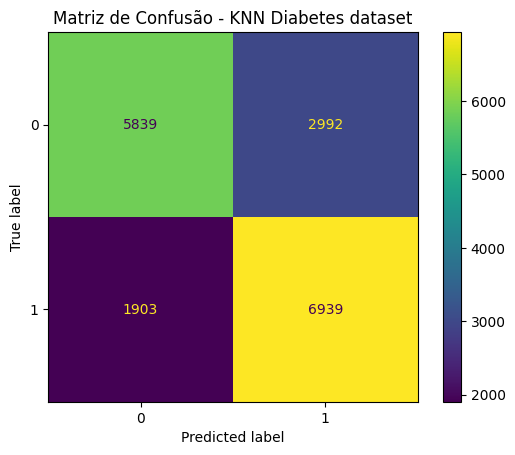

In [48]:
matriz_confusao = confusion_matrix(y_teste, knn.predict(X_teste))
mc = ConfusionMatrixDisplay(matriz_confusao)
mc.plot()
plt.title('Matriz de Confusão - KNN Diabetes dataset')

- a matriz de confusão mostra uma alta taxa de resultados erro nas previsões, apesar de o indice de verdadeiros positivos ser o mais relevante.
- Para fins Clínicos o modelo não é confiável, pois tem de se considerar que em casos médicos e necessária uma precisão muito rigorosa para evitar frustrações ou procedimentos inadequados ao paciente.

### Conclusão:
Os dados, apesar de serem em quantidade considerável, não conseguem representar adequadamente um padrão para que os classificadores, principalmente o KNN, consigam classificar adequadamente. Mesmo com a transformada PCA, própria para expressar melhor os dados com muitas variáveis, não foi suficiente para criar um modelo robusto para prever casos clínicos. Infelizmente é um problema de features não representativas para a classificação desejada.